In [1]:
import os
import glob
import numpy as np
import mahotas as mh
import pandas as pd

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/240628_ARMC5_EU/Cycle2_EU"
image_dir = os.path.join(data_dir,"20240701_175159_151/OME-TIFF-MIP")
label_image_dir = os.path.join(data_dir,"20240701_175159_151/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hct116_EU"
illum_corr_file = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/ILLUMCORR/illumination_correction.pkl"

25-Jul-24 15:35:00 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [3]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240628_ARMC5KD_EU.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['well_name'] = plate_layout['WELL'].apply(lambda x: pad_well_names(x))

## Apply illumination correction

Load illumination correction object

In [4]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [5]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata['well_name'] = image_metadata['filename_ome_tiff'].str.extract(r'Well([A-Z]\d{2})_Channel')
image_metadata.columns

Index(['n_pixels_y', 'n_pixels_x', 'objective_name', 'pixel_size_microns',
       'field_id', 'timepoint_id', 'filename_ome_tiff', 'acquisition_time_rel',
       'stage_y_abs', 'stage_x_abs', 'stage_z_n', 'acquisition_time_abs',
       'standard_field_id', 'metadata_string_acquisition_0',
       'metadata_string_acquisition_1', 'well_name'],
      dtype='object')

In [6]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="well_name", right_on="well_name")

In [7]:
image_metadata_annotated.query(
    "CELL == 'HCT116' and field_id == 1 and EU == '100 µM'")

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,...,standard_field_id,metadata_string_acquisition_0,metadata_string_acquisition_1,well_name,WELL,CELL,SIRNA,PRIMARY,SECONDARY,EU
0,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC06_Channel647,405_Seq0003_0001.ome.tiff",518.046081,-25615.342857,29762.900000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C06,C6,HCT116,ARMC5 pool,Total Pol II,Anti-mouse 561,100 µM
9,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC08_Channel647,405_Seq0005_0001.ome.tiff",851.028722,-25622.785714,20755.500000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C08,C8,HCT116,ARMC5 pool,Total Pol II,Anti-mouse 561,100 µM
18,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC04_Channel647,405_Seq0001_0001.ome.tiff",184.569163,-25608.028571,38770.600000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C04,C4,HCT116,ARMC5 pool,Total Pol II,Anti-mouse 561,100 µM
36,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC07_Channel647,405_Seq0004_0001.ome.tiff",684.005956,-25619.000000,25259.200000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C07,C7,HCT116,Scramble,Total Pol II,Anti-mouse 561,100 µM
72,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC03_Channel647,405_Seq0000_0001.ome.tiff",16.155628,-25604.500000,43274.542857,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C03,C3,HCT116,Scramble,Total Pol II,Anti-mouse Alexa561,100 µM
81,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD06_Channel647,405_Seq0008_0001.ome.tiff",1352.436107,-21123.457143,29719.200000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,D06,D6,HCT116,Scramble,Total Pol II,Anti-mouse 561,100 µM
90,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD08_Channel647,405_Seq0006_0001.ome.tiff",1018.535915,-21131.042857,20711.700000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,D08,D8,HCT116,Scramble,Total Pol II,Anti-mouse 561,100 µM
99,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD05_Channel647,405_Seq0009_0001.ome.tiff",1518.867715,-21120.000000,34223.100000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,D05,D5,HCT116,ARMC5 pool,Total Pol II,Anti-mouse 561,100 µM
108,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellD07_Channel647,405_Seq0007_0001.ome.tiff",1186.040595,-21127.300000,25215.500000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,D07,D7,HCT116,ARMC5 pool,Total Pol II,Anti-mouse 561,100 µM
117,2304,2304,Plan Apo VC 20x DIC N2,0.324272,1,0,"WellC05_Channel647,405_Seq0002_0001.ome.tiff",351.701741,-25611.700000,34266.800000,...,3,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,C05,C5,HCT116,Scramble,Total Pol II,Anti-mouse 561,100 µM


## Save Examples

In [8]:
example_images = image_metadata_annotated.query("field_id == 4")[['filename_ome_tiff','CELL','SIRNA','EU','well_name']]
example_images['new_filename'] = example_images['CELL'] + '_' + example_images['SIRNA'] + '_' + example_images['EU'] + '_' + example_images['well_name'] + '.png'
example_images['new_filename_overlay'] = example_images['CELL'] + '_' + example_images['SIRNA'] + '_' + example_images['EU'] + '_' + example_images['well_name'] + '_nuclei.png'
example_images['filename_segmentation'] = 'nuclei_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group'] = 'A'

In [9]:
example_images

,filename_ome_tiff,CELL,SIRNA,EU,well_name,new_filename,new_filename_overlay,filename_segmentation,intensity_rescaling_group
3,"WellC06_Channel647,405_Seq0003_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C06,HCT116_ARMC5 pool_100 µM_C06.png,HCT116_ARMC5 pool_100 µM_C06_nuclei.png,"nuclei_WellC06_Channel647,405_Seq0003_0004.ome...",A
12,"WellC08_Channel647,405_Seq0005_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C08,HCT116_ARMC5 pool_100 µM_C08.png,HCT116_ARMC5 pool_100 µM_C08_nuclei.png,"nuclei_WellC08_Channel647,405_Seq0005_0004.ome...",A
21,"WellC04_Channel647,405_Seq0001_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C04,HCT116_ARMC5 pool_100 µM_C04.png,HCT116_ARMC5 pool_100 µM_C04_nuclei.png,"nuclei_WellC04_Channel647,405_Seq0001_0004.ome...",A
30,"WellF06_Channel647,405_Seq0020_0004.ome.tiff",HCT116,No reaction,No EU,F06,HCT116_No reaction_No EU_F06.png,HCT116_No reaction_No EU_F06_nuclei.png,"nuclei_WellF06_Channel647,405_Seq0020_0004.ome...",A
39,"WellC07_Channel647,405_Seq0004_0004.ome.tiff",HCT116,Scramble,100 µM,C07,HCT116_Scramble_100 µM_C07.png,HCT116_Scramble_100 µM_C07_nuclei.png,"nuclei_WellC07_Channel647,405_Seq0004_0004.ome...",A
48,"WellF04_Channel647,405_Seq0022_0004.ome.tiff",HCT116,No reaction,No EU,F04,HCT116_No reaction_No EU_F04.png,HCT116_No reaction_No EU_F04_nuclei.png,"nuclei_WellF04_Channel647,405_Seq0022_0004.ome...",A
57,"WellF05_Channel647,405_Seq0021_0004.ome.tiff",HCT116,No reaction,No EU,F05,HCT116_No reaction_No EU_F05.png,HCT116_No reaction_No EU_F05_nuclei.png,"nuclei_WellF05_Channel647,405_Seq0021_0004.ome...",A
66,"WellF03_Channel647,405_Seq0023_0004.ome.tiff",HCT116,No reaction,No EU,F03,HCT116_No reaction_No EU_F03.png,HCT116_No reaction_No EU_F03_nuclei.png,"nuclei_WellF03_Channel647,405_Seq0023_0004.ome...",A
75,"WellC03_Channel647,405_Seq0000_0004.ome.tiff",HCT116,Scramble,100 µM,C03,HCT116_Scramble_100 µM_C03.png,HCT116_Scramble_100 µM_C03_nuclei.png,"nuclei_WellC03_Channel647,405_Seq0000_0004.ome...",A
84,"WellD06_Channel647,405_Seq0008_0004.ome.tiff",HCT116,Scramble,100 µM,D06,HCT116_Scramble_100 µM_D06.png,HCT116_Scramble_100 µM_D06_nuclei.png,"nuclei_WellD06_Channel647,405_Seq0008_0004.ome...",A


In [10]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [11]:
%%capture
example_images_grouped = example_images.query("SIRNA == 'ARMC5 pool' & EU!='No EU'").groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        EU_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
        upper_rescale_value.append(np.quantile(EU_array,0.99))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [12]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [13]:
example_images

,filename_ome_tiff,CELL,SIRNA,EU,well_name,new_filename,new_filename_overlay,filename_segmentation,intensity_rescaling_group,upper_rescale_value
0,"WellC06_Channel647,405_Seq0003_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C06,HCT116_ARMC5 pool_100 µM_C06.png,HCT116_ARMC5 pool_100 µM_C06_nuclei.png,"nuclei_WellC06_Channel647,405_Seq0003_0004.ome...",A,711.0
1,"WellC08_Channel647,405_Seq0005_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C08,HCT116_ARMC5 pool_100 µM_C08.png,HCT116_ARMC5 pool_100 µM_C08_nuclei.png,"nuclei_WellC08_Channel647,405_Seq0005_0004.ome...",A,711.0
2,"WellC04_Channel647,405_Seq0001_0004.ome.tiff",HCT116,ARMC5 pool,100 µM,C04,HCT116_ARMC5 pool_100 µM_C04.png,HCT116_ARMC5 pool_100 µM_C04_nuclei.png,"nuclei_WellC04_Channel647,405_Seq0001_0004.ome...",A,711.0
3,"WellF06_Channel647,405_Seq0020_0004.ome.tiff",HCT116,No reaction,No EU,F06,HCT116_No reaction_No EU_F06.png,HCT116_No reaction_No EU_F06_nuclei.png,"nuclei_WellF06_Channel647,405_Seq0020_0004.ome...",A,711.0
4,"WellC07_Channel647,405_Seq0004_0004.ome.tiff",HCT116,Scramble,100 µM,C07,HCT116_Scramble_100 µM_C07.png,HCT116_Scramble_100 µM_C07_nuclei.png,"nuclei_WellC07_Channel647,405_Seq0004_0004.ome...",A,711.0
5,"WellF04_Channel647,405_Seq0022_0004.ome.tiff",HCT116,No reaction,No EU,F04,HCT116_No reaction_No EU_F04.png,HCT116_No reaction_No EU_F04_nuclei.png,"nuclei_WellF04_Channel647,405_Seq0022_0004.ome...",A,711.0
6,"WellF05_Channel647,405_Seq0021_0004.ome.tiff",HCT116,No reaction,No EU,F05,HCT116_No reaction_No EU_F05.png,HCT116_No reaction_No EU_F05_nuclei.png,"nuclei_WellF05_Channel647,405_Seq0021_0004.ome...",A,711.0
7,"WellF03_Channel647,405_Seq0023_0004.ome.tiff",HCT116,No reaction,No EU,F03,HCT116_No reaction_No EU_F03.png,HCT116_No reaction_No EU_F03_nuclei.png,"nuclei_WellF03_Channel647,405_Seq0023_0004.ome...",A,711.0
8,"WellC03_Channel647,405_Seq0000_0004.ome.tiff",HCT116,Scramble,100 µM,C03,HCT116_Scramble_100 µM_C03.png,HCT116_Scramble_100 µM_C03_nuclei.png,"nuclei_WellC03_Channel647,405_Seq0000_0004.ome...",A,711.0
9,"WellD06_Channel647,405_Seq0008_0004.ome.tiff",HCT116,Scramble,100 µM,D06,HCT116_Scramble_100 µM_D06.png,HCT116_Scramble_100 µM_D06_nuclei.png,"nuclei_WellD06_Channel647,405_Seq0008_0004.ome...",A,711.0


In [14]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    EU_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)
    lower_rescale_value = 120
    EU_array_rescaled = (EU_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(EU_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0)
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)


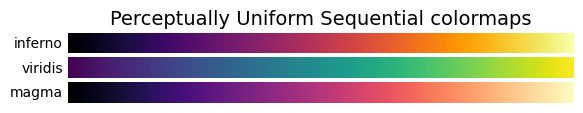

In [15]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))

In [16]:
example_dir

PosixPath('/srv/scratch/berrylab/z3532965/NikonSpinningDisk/ARMC5_KD_EU/240628_ARMC5_EU/Cycle2_EU/20240701_175159_151/EXAMPLES/RGB')

In [17]:
aics_image.channel_names

['647', '405']